In [1]:
!wget "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"

--2023-04-08 00:16:29--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.227.254.11, 13.227.254.97, 13.227.254.42, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.227.254.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   157MB/s    in 2.1s    

2023-04-08 00:16:32 (157 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [2]:
!unzip cell_images -d /content

Streaming output truncated to the last 5000 lines.
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: /content/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: /content/cell_images/Uninfected/C236T

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

#Size of our input images
SIZE = 128



In [4]:
#############################################################################
# making a set of test samples and copy the rest to images folders
import os
import random
import shutil
!mkdir cell_images/uninfected_test
!mkdir cell_images/uninfected_test/images
source = 'cell_images/Uninfected'
dest = 'cell_images/uninfected_test/images'
files = os.listdir(source)
no_of_files = len(files) // 182

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)
    
!mkdir cell_images/Parasitized/images
source = 'cell_images/Parasitized'
dest = 'cell_images/Parasitized/images'
files = os.listdir(source)
no_of_files = len(files) 

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)

!mkdir cell_images/Uninfected/images
source = 'cell_images/Uninfected'
dest = 'cell_images/Uninfected/images'
files = os.listdir(source)
no_of_files = len(files) 

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)

In [5]:
#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'cell_images/Uninfected/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'cell_images/uninfected_test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'cell_images/Parasitized/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 13704 images belonging to 1 classes.
Found 75 images belonging to 1 classes.
Found 13779 images belonging to 1 classes.


In [6]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [7]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


Epoch 1/1000
7/7 [==============================] - 15s 173ms/step - loss: 0.0877 - mse: 0.0877 - val_loss: 0.0783 - val_mse: 0.0783
Epoch 2/1000
7/7 [==============================] - 1s 179ms/step - loss: 0.0620 - mse: 0.0620 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 3/1000
7/7 [==============================] - 2s 217ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 4/1000
7/7 [==============================] - 1s 128ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 5/1000
7/7 [==============================] - 1s 168ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6/1000
7/7 [==============================] - 1s 133ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 7/1000
7/7 [==============================] - 1s 129ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 8/1000
7/7 [==============================] - 1s 134ms/step - loss: 0

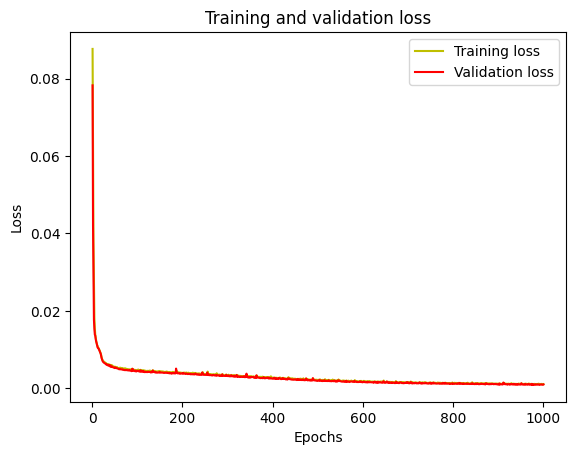

In [8]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


2/2 [==============================] - 1s 8ms/step


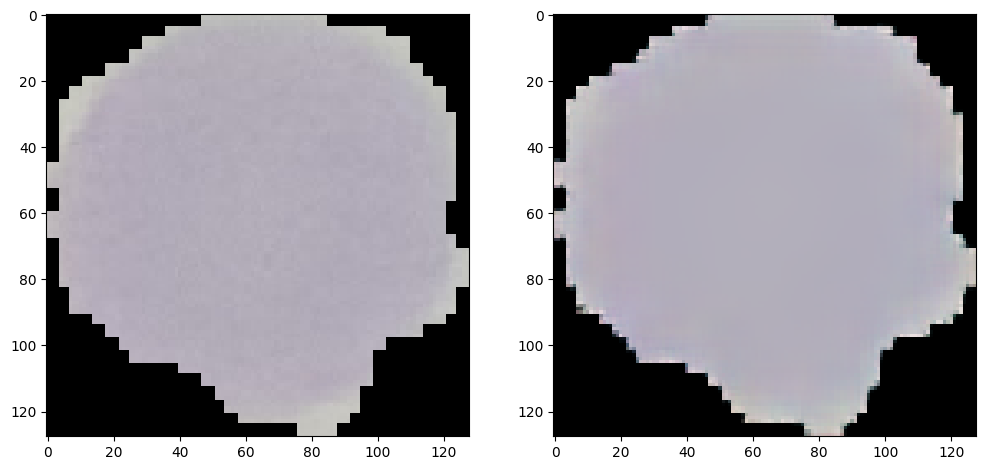

In [24]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [25]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)


<ipython-input-25-8dc36ded4cad>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)
<ipython-input-25-8dc36ded4cad>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.0009874773677438498, 0.0009874773677438498]
Recon. error for the anomaly data is:  [0.001664063660427928, 0.001664063660427928]


In [26]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [28]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)


<ipython-input-28-bd7cf74ec2f6>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [30]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error


In [31]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


1/1 [==============================] - 0s 27ms/step - loss: 0.0074 - mse: 0.0074


In [32]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
    

1/1 [==============================] - 0s 23ms/step - loss: 0.0035 - mse: 0.0035
The image is an anomaly


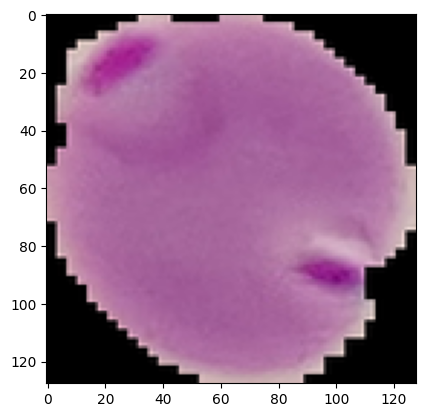

In [41]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('cell_images/Parasitized/images/*')
uninfected_file_paths = glob.glob('cell_images/Uninfected/images/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])



1/1 [==============================] - 0s 24ms/step - loss: 0.0036 - mse: 0.0036
The image is NOT an anomaly


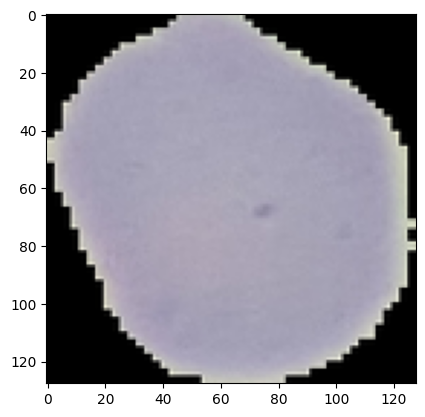

In [46]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])